In [1]:
import glob
import pandas as pd
import nibabel as nb
import numpy as np
from nistats.second_level_model import SecondLevelModel
from nistats.thresholding import map_threshold
from nilearn import plotting


/data/softwares/anaconda3/2019.10/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# importing rmaps

In [2]:
networks = ['CER','LIM','MOT','VIS','DMN','FP','VATT_SAL']

nets_rmaps = {}
for net in networks:
    connectivity_maps = glob.glob("../rest/rmap_seeds/*sub*_"+net+".nii.gz")
    rmap_list = []
    for rmap in connectivity_maps:
        rmap_list.append(rmap)
    nets_rmaps[net] = rmap_list
        

In [3]:
len(nets_rmaps["CER"])

112

In [4]:
len(nets_rmaps.keys())

7

# import csv file 

In [5]:
cimaq_diagnostic = '../../cimaq_csv/cimaq_diagnostic_Nov_2019.csv'
cimaq_diagnostic = pd.read_csv(cimaq_diagnostic)


print(set(cimaq_diagnostic['V01 36448_diagnostic_clinique,36448_diagnostic_clinique'].values))
cimaq_diagnostic = cimaq_diagnostic[['V01 demographics,CandID','V01 36448_diagnostic_clinique,36448_diagnostic_clinique']]
cimaq_diagnostic.rename(columns = {"V01 demographics,CandID":"subID","V01 36448_diagnostic_clinique,36448_diagnostic_clinique":"diagnostic" },inplace=True)
cimaq_diagnostic

{'troubles_subjectifs_de_cognition', 'cognitivement_sain_(cs)', 'trouble_cognitif_léger_précoce', 'trouble_cognitif_léger_tardif', 'démence_de_type_alzheimer-légère'}


,subID,diagnostic
0,327986,troubles_subjectifs_de_cognition
1,934539,démence_de_type_alzheimer-légère
2,368387,troubles_subjectifs_de_cognition
3,658178,troubles_subjectifs_de_cognition
4,641853,troubles_subjectifs_de_cognition
...,...,...
309,654431,démence_de_type_alzheimer-légère
310,774096,troubles_subjectifs_de_cognition
311,467954,trouble_cognitif_léger_tardif
312,203982,démence_de_type_alzheimer-légère


In [6]:

cimaq_diagnostic["contrast"] = 7
subjectID_set = set([sub.split("sub")[1].split("_")[0] for sub in nets_rmaps["CER"]])
for i,r in cimaq_diagnostic.iterrows():
    
    if(str(r["subID"]) in subjectID_set):
       
        if(r["diagnostic"] == "troubles_subjectifs_de_cognition"):
            cimaq_diagnostic.loc[i,"contrast"] = 1
        if(r["diagnostic"] == "cognitivement_sain_(cs)"):
            cimaq_diagnostic.loc[i,"contrast"] = -1          
        
        if("trouble_cognitif_léger" in r["diagnostic"]):
            cimaq_diagnostic.loc[i,"contrast"] = 0
            
        cimaq_diagnostic.loc[i,"subID"] = str(r["subID"])
        
cimaq_diagnostic

,subID,diagnostic,contrast
0,327986,troubles_subjectifs_de_cognition,7
1,934539,démence_de_type_alzheimer-légère,7
2,368387,troubles_subjectifs_de_cognition,7
3,658178,troubles_subjectifs_de_cognition,1
4,641853,troubles_subjectifs_de_cognition,7
...,...,...,...
309,654431,démence_de_type_alzheimer-légère,7
310,774096,troubles_subjectifs_de_cognition,7
311,467954,trouble_cognitif_léger_tardif,0
312,203982,démence_de_type_alzheimer-légère,7


In [7]:
cimaq_diagnostic = cimaq_diagnostic.loc[(cimaq_diagnostic["contrast"] != 7)]
cimaq_diagnostic

,subID,diagnostic,contrast
3,658178,troubles_subjectifs_de_cognition,1
7,920577,troubles_subjectifs_de_cognition,1
10,199801,trouble_cognitif_léger_tardif,0
11,254530,troubles_subjectifs_de_cognition,1
16,748676,trouble_cognitif_léger_précoce,0
...,...,...,...
296,785245,troubles_subjectifs_de_cognition,1
299,778749,troubles_subjectifs_de_cognition,1
306,560180,trouble_cognitif_léger_précoce,0
311,467954,trouble_cognitif_léger_tardif,0


In [8]:
design_matrix = cimaq_diagnostic[["contrast"]]

design_matrix.values

array([[ 1],
       [ 1],
       [ 0],
       [ 1],
       [ 0],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 0],
       [ 1],
       [ 0],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 0],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 0],
       [ 1],
       [ 1],
       [ 1],
       [ 0],
       [-1],
       [ 1],
       [ 0],
       [ 1],
       [ 0],
       [ 1],
       [ 0],
       [ 1],
       [ 1],
       [ 0],
       [ 1],
       [ 1],
       [ 0],
       [ 1],
       [ 0],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 0],
       [ 1],
       [ 1],
       [ 0],
       [ 1],
       [ 1],
       [ 1],
       [ 0],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 0],

In [9]:
network_interest = "DMN"
rmaps = nets_rmaps[network_interest]


In [10]:
#Select the rmaps that are SCD and CN

import re
second_level_input = []
for i in rmaps:
    sub = re.search("\d\d\d\d\d\d",i)
    
    subid = sub.group(0)
    #print(subid)
    if(subid in set(cimaq_diagnostic["subID"].values)):
        
        second_level_input.append(i)
        
len(second_level_input)

99

In [11]:
#Calculate the glm and zmap
second_level_model = SecondLevelModel().fit(second_level_input, design_matrix=design_matrix)
z_map = second_level_model.compute_contrast(output_type='z_score')

In [12]:
thresholded_map1, threshold1 = map_threshold(
    z_map, alpha=.1, height_control='fpr', cluster_threshold=10)

In [13]:
thresholded_map3, threshold3 = map_threshold(
    z_map, alpha=5, height_control='bonferroni')
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold3)

The p<.05 Bonferroni-corrected threshold is 4.03


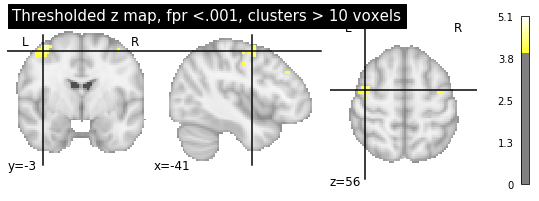

In [14]:
plotting.plot_stat_map(
    thresholded_map3, threshold=threshold3,
    title='Thresholded z map, fpr <.001, clusters > 10 voxels')